In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the predictive models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
from xgboost import XGBClassifier as XGB
import lightgbm as lgb

# Removing annoying warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced = 'no'):
    a = classification_report(true, predictions, output_dict = True)
    zeros = pd.DataFrame(data = a['0'], index = [0]).iloc[:,0:3].add_suffix('_0')
    ones = pd.DataFrame(data = a['1'], index = [0]).iloc[:,0:3].add_suffix('_1')
    df = pd.concat([zeros, ones], axis = 1)
    temp = list(df)
    df['Model'] = model_name
    df['Balanced'] = balanced
    df['Accuracy'] = accuracy_score(true, predictions)
    df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    df['AUC'] = roc_auc_score(true, predictions_proba, average = 'macro')
    df = df[['Model', 'Balanced', 'Accuracy', 'Balanced_Accuracy', 'AUC'] + temp]
    return df

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
data = pd.read_csv('Cleaned_Data.csv')
data.head()

,CustomerId,Surname,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,0,42,2,119808.30,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,0,39,1,119808.30,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# One-Hot encoding our categorical attributes
list_cat = ['Country', 'Gender']
data = pd.get_dummies(data, columns = list_cat, prefix = list_cat, dtype=int)
data.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain,Gender_0,Gender_1
0,15634602,Hargrave,619,42,2,119808.30,1,1,1,101348.88,1,1,0,0,1,0
1,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,15701354,Boni,699,39,1,119808.30,2,0,0,93826.63,0,1,0,0,1,0
4,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [ ]:
data = data.drop(['CustomerId', 'Surname'], axis = 1)

In [ ]:
features = list(data.drop('Exited', axis = 1))
target = 'Exited'

In [ ]:

train, test = train_test_split(data, test_size = 0.2, random_state = 1)

print('Number of clients in the dataset: {}'.format(len(data)))
print('Number of clients in the train set: {}'.format(len(train)))
print('Number of clients in the test set: {}'.format(len(test)))

Number of clients in the dataset: 9626
Number of clients in the train set: 7700
Number of clients in the test set: 1926


In [ ]:
sc = StandardScaler()

# fit on training set
train[features] = sc.fit_transform(train[features])

# only transform on test set
test[features] = sc.transform(test[features])

In [ ]:
def resample_data(data, target):
    data_1 = data[data[target] == 1]
    data_0 = data[data[target] == 0]
    percentage = len(data_1)/len(data_0)
    temp = data_0.sample(frac = percentage, random_state = 1)

    data_new = data_1.append(temp)
    data_new.sort_index(inplace = True)
    return data_new

In [ ]:
def resample_data(data, target):
    majority = data[data[target] == 0]
    minority = data[data[target] == 1]
    minority_upsampled = minority.sample(len(majority), replace=True)
    return pd.concat([majority, minority_upsampled])  # ✅ Updated


In [ ]:
trainB = resample_data(train, target = target)
print('Number of clients in the dataset is : {}'.format(len(data)))
print('Number of clients in the balanced train set is : {}'.format(len(trainB)))
print('Number of clients in the test set is : {}'.format(len(test)))

Number of clients in the dataset is : 9626
Number of clients in the balanced train set is : 12276
Number of clients in the test set is : 1926


In [ ]:
exited_trainB = len(trainB[trainB['Exited'] == 1]['Exited'])
exited_trainB_perc = round(exited_trainB/len(trainB)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Balanced Train set - Number of clients that have exited the program: {} ({}%)'.format(exited_trainB, exited_trainB_perc))
print('Test set - Number of clients that haven\'t exited the program: {} ({}%)'.format(exited_test, exited_test_perc))

Balanced Train set - Number of clients that have exited the program: 6138 (50.0%)
Test set - Number of clients that haven't exited the program: 387 (20.1%)


2.5.1 Logistic Regresstion

In [ ]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_LR.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.151956,0.038257,0.022682,0.011551,0.01,50,newton-cg,"{'C': 0.01, 'max_iter': 50, 'solver': 'newton-...",0.719463,0.729124,0.716090,0.697352,0.726273,0.717660,0.011169,11
1,0.165663,0.043187,0.038343,0.018707,0.01,50,lbfgs,"{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}",0.719463,0.729124,0.716904,0.698167,0.726273,0.717986,0.010852,1
2,0.145969,0.011875,0.025037,0.007696,0.01,50,liblinear,"{'C': 0.01, 'max_iter': 50, 'solver': 'libline...",0.714984,0.731568,0.715275,0.699389,0.725458,0.717335,0.010958,55
3,0.623192,0.015205,0.023195,0.004659,0.01,50,sag,"{'C': 0.01, 'max_iter': 50, 'solver': 'sag'}",0.719463,0.729124,0.716497,0.698167,0.726273,0.717905,0.010862,4
4,0.700821,0.082821,0.026673,0.001002,0.01,50,saga,"{'C': 0.01, 'max_iter': 50, 'solver': 'saga'}",0.719463,0.729124,0.716497,0.697760,0.726273,0.717823,0.011010,8
5,0.160432,0.017630,0.018104,0.006618,0.01,100,newton-cg,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.719463,0.729124,0.716090,0.697352,0.726273,0.717660,0.011169,11
6,0.113234,0.007473,0.019943,0.004193,0.01,100,lbfgs,"{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}",0.719463,0.729124,0.716904,0.698167,0.726273,0.717986,0.010852,1
7,0.142419,0.045766,0.018607,0.007121,0.01,100,liblinear,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.714984,0.731568,0.715275,0.699389,0.725458,0.717335,0.010958,55
8,0.539587,0.039045,0.016161,0.002741,0.01,100,sag,"{'C': 0.01, 'max_iter': 100, 'solver': 'sag'}",0.719463,0.729124,0.716497,0.697760,0.726273,0.717823,0.011010,8
9,0.713839,0.145796,0.026743,0.004728,0.01,100,saga,"{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}",0.719463,0.729124,0.716497,0.698167,0.726273,0.717905,0.010862,4


In [ ]:
print(model_LR.best_params_)

{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}


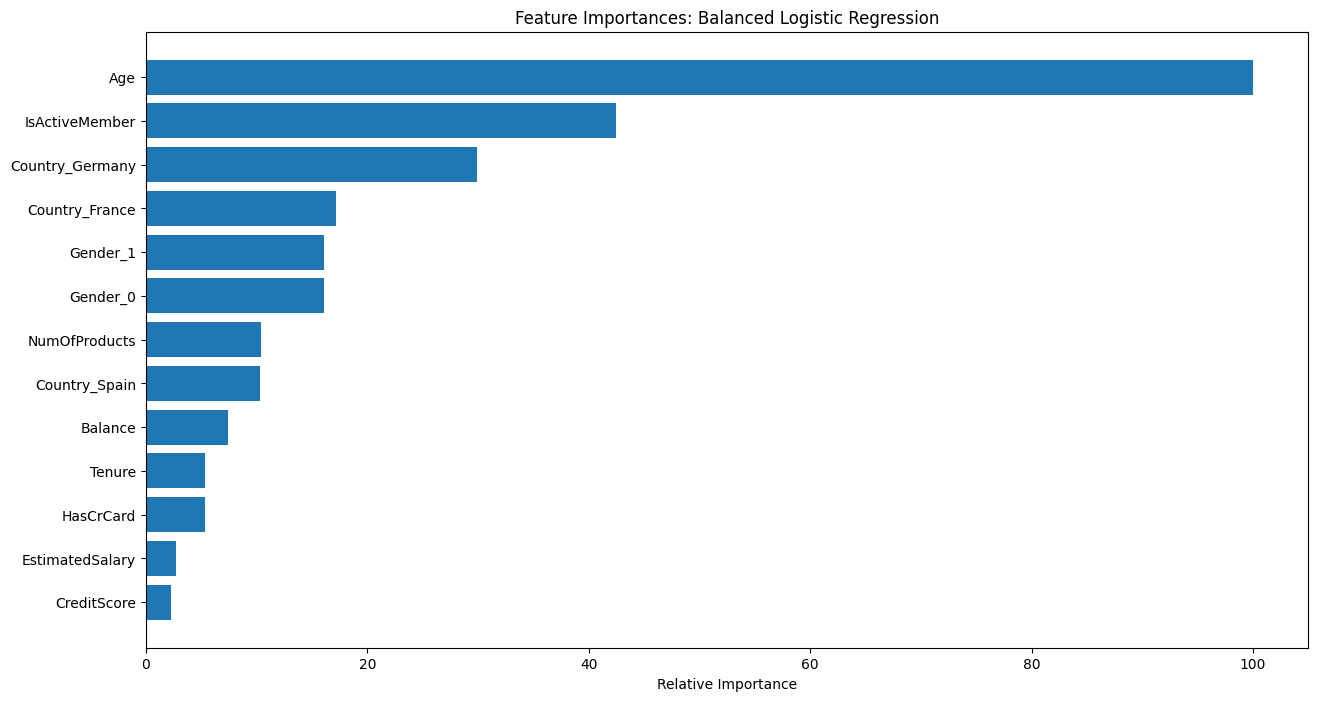

In [ ]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(trainB[features], trainB[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

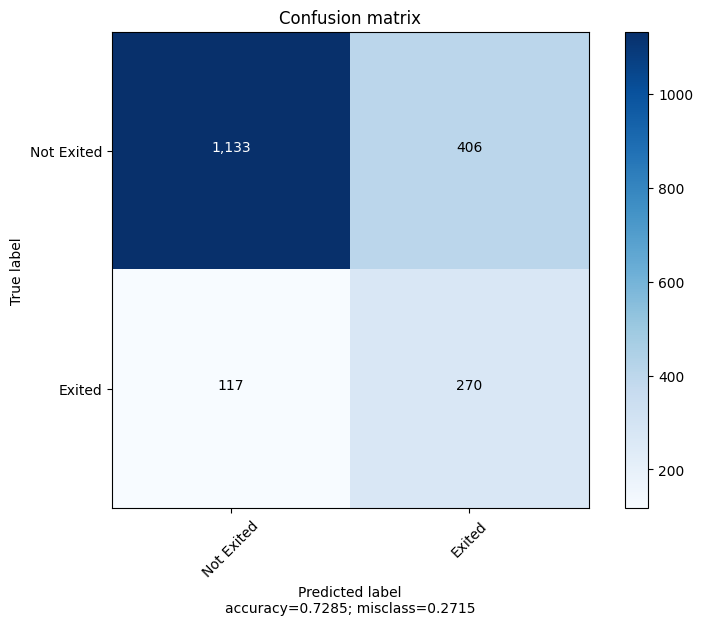

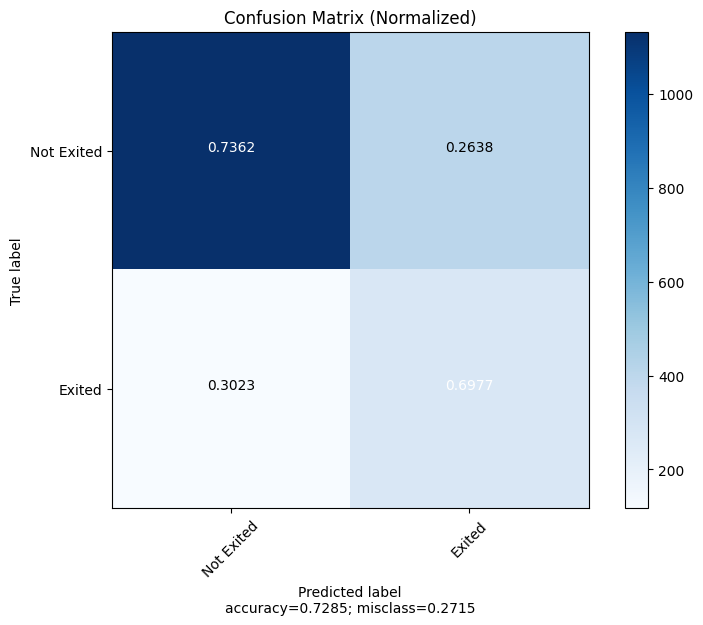

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.728453,0.716933,0.782763,0.9064,0.736192,0.812478,0.399408,0.697674,0.507996


In [ ]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

table_of_models = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression')
table_of_models

2.5.3 Gradient Boosting Classifier (Sklearn)

In [ ]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB,
                        parameters,
                        cv = 5,
                        n_jobs = 10,
                        verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_GB.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.899844,0.278122,0.046457,0.021612,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.774023,0.786151,0.779633,0.767413,0.775560,0.776556,0.006205,24
1,10.832057,0.131762,0.040389,0.008286,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.785831,0.791039,0.780041,0.768635,0.779633,0.781036,0.007480,23
2,30.097196,0.471349,0.099623,0.028160,2,300,"{'max_depth': 2, 'n_estimators': 300}",0.801710,0.802851,0.792261,0.784929,0.804073,0.797165,0.007409,20
3,48.416754,1.021135,0.146138,0.048528,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.811482,0.807332,0.798371,0.793075,0.816701,0.805392,0.008599,18
4,7.600676,0.213949,0.048416,0.005642,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.785831,0.795519,0.786151,0.772709,0.785336,0.785109,0.007264,22
5,14.291109,0.298569,0.052612,0.005472,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.800896,0.804888,0.788595,0.784929,0.795927,0.795047,0.007427,21
6,42.876250,0.449311,0.114383,0.015142,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.838762,0.828106,0.821589,0.814664,0.836660,0.827956,0.009053,16
7,70.963176,0.877064,0.216111,0.049216,3,500,"{'max_depth': 3, 'n_estimators': 500}",0.849756,0.854582,0.845621,0.837067,0.846843,0.846774,0.005752,14
8,8.940909,0.817483,0.055296,0.019009,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.798046,0.812220,0.795519,0.782892,0.800815,0.797898,0.009429,19
9,18.550266,0.761714,0.088525,0.015098,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.815961,0.823218,0.813849,0.804481,0.819145,0.815331,0.006278,17


In [ ]:
print(model_GB.best_params_)

{'max_depth': 15, 'n_estimators': 300}


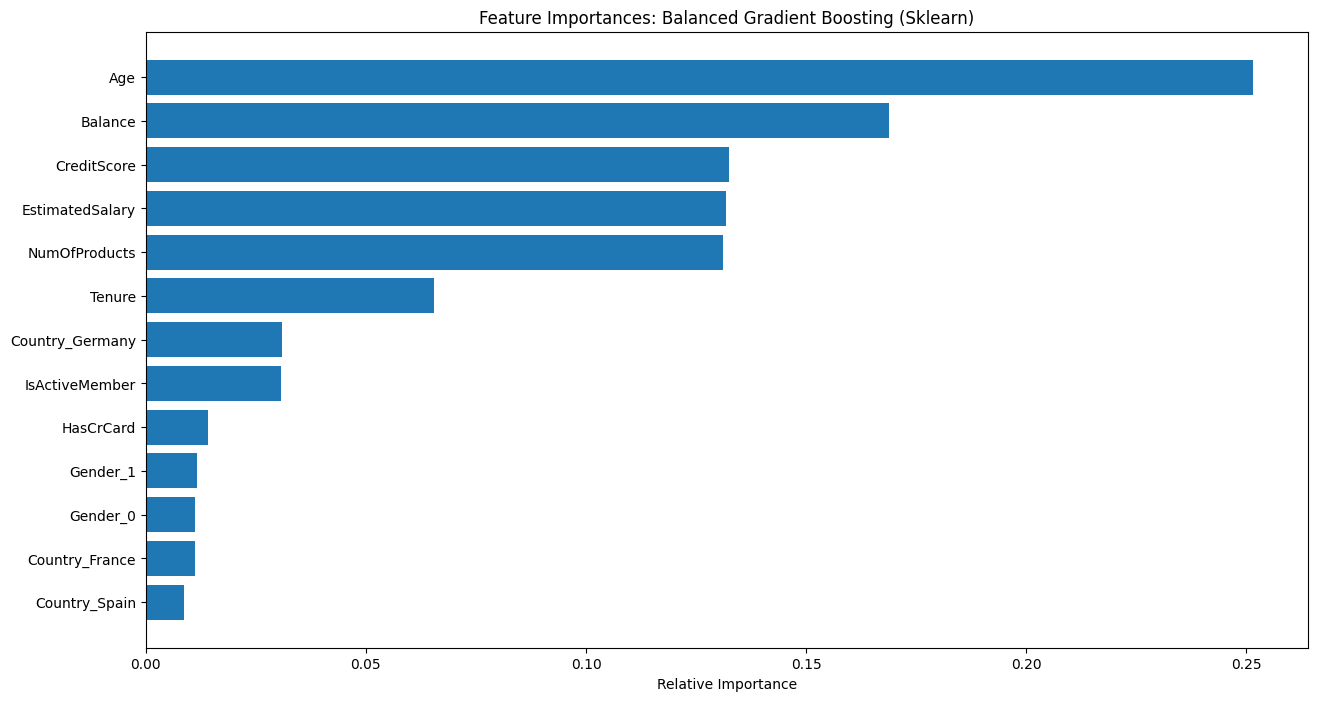

In [ ]:
model = GBSklearn(**model_GB.best_params_)
model.fit(trainB[features], trainB[target])

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

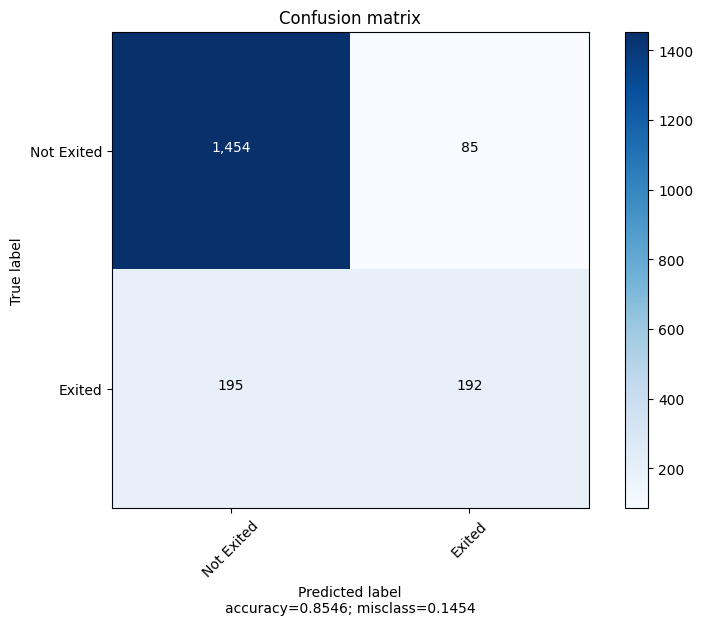

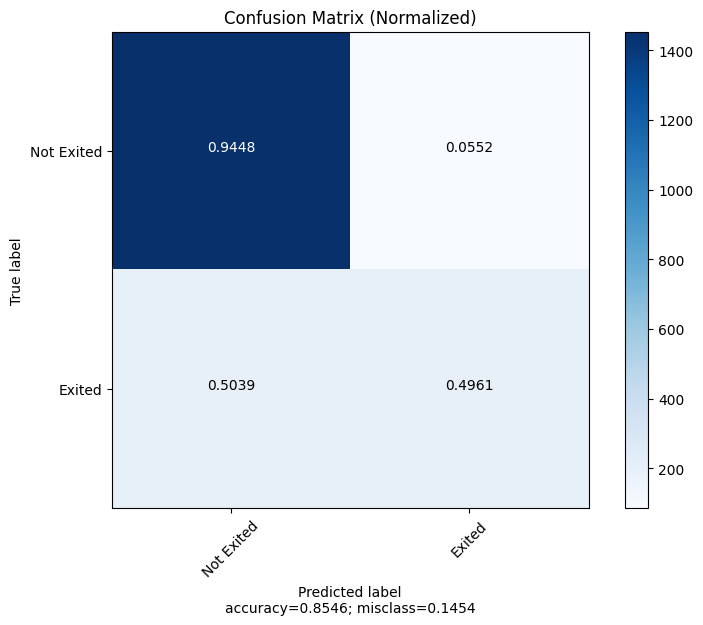

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (Sklearn),yes,0.854621,0.720447,0.841299,0.881747,0.944769,0.912171,0.693141,0.496124,0.578313


In [ ]:
pred = model_GB.predict(test[features])
predp = model_GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (Sklearn)', balanced = 'yes')
temp